In [58]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import astropy.units as u
params = {
         'axes.labelsize': 20,
         'axes.titlesize': 20,
         'ytick.labelsize' :20,
         'xtick.labelsize' :20,
         'legend.fontsize': 15,
         'xtick.major.size': 8,
         'xtick.minor.size': 4,
         'xtick.major.width': 3,
         'xtick.minor.width': 2,
         'ytick.major.size': 8,
         'ytick.minor.size': 4,
         'ytick.major.width': 3,
         'ytick.minor.width': 2,
         'ytick.color': "k",
         'xtick.color': "k",
         'axes.labelcolor': "k",
         'ytick.labelcolor' : "k",
         'xtick.labelcolor' : "k",
         'font.size': 15
         }
plt.rcParams.update(params)
plt.style.use('science')

KeyError: 'xtick.major.length is not a valid rc parameter (see rcParams.keys() for a list of valid parameters)'

In [59]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'b

## Frequentist vs Bayesian linear regression
In many fields, we are interested in estimating parameters of interest given some observables (i.e. the measured data). For us, physicists, the parameters of interest are physical quantities informing us about the laws of nature. Often, these laws follow linear trends according to some physical parameters and we're interested in doing linear regression, i.e. given some noisy observed data and a physical model, determining the underlying physical parameters and see if they are agreeing with the physical model. This linear regression can be done in two manners, the frequentist way or the Bayesian way. 

In this notebook, I'll explore two types of linear regression characterized by different visions of statistics. I won't delve really deep in what is implied for each one of this view but to put it simply: 
- __Frequentist view__: probabilities are viewed as the frequency at which an event repeats itself in an experiment
- __Bayesian view__:  probabilites are viewed as a degree of belief/confidence.

In the parameter estimation ocurring during linear regression, frequentists assume a confidence interval (for example 95%) around a **fixed parameter of interest** and use statistical tests to do hypothesis testing (i.e. check if the observed data is consistent with a null hypothesis). The problem is that there's no clear way on how to define this confidence interval and you might be sometimes in situations where, even though the null hypothesis is correct, you reject it due to a poor choice of confidence interval.  

The Bayesian view is more elegant (in my opinion). Instead of assuming a fixed parameter of interest, the **parameter of interest becomes a random variable** following a **posterior distribution**. I'll go into more details when the time comes but this approach is powerful since it allows you to bypass the problems ocurring when you need to choose p-values or confidence intervals. Instead, the information loss due to noise is naturally included in the framework and more complex cases (like multimodality for example) can be encoded. 

Enough babbling about frequentist vs Bayesian. Let's get started with linear regression. Linear regression is the problem of finding the optimal regression coefficients $\beta$ given observed data $\mathbf{y}$ such that
$$
\mathbf{y}^\star = \beta \mathbf{x} \qquad \mathbf{y} = \beta \mathbf{x} + \boldsymbol{\epsilon}
$$
where $\boldsymbol{\epsilon} \sim  \mathcal{N}(0, \Sigma)$ is noise (estimated during the experiment in our case).


### A simple toy problem
Let's imagine we're back in year 1 and doing our first class of Classical Mechanics. One of the first derivation that we can make is simply the linear relationship between position $x(t)$ and at constant speed $v(t)=v_0$ when there is no acceleration (no force on the system). This means we can write
$$
x(t) = x_{0} + \int_{0}^{t} \frac{dx}{dt'} dt'\rightarrow x(t)= x_{0} + v_0 t
$$

Great. Now, let's assume that we have a bowling ball that we launch at speed $v_{0}$ from a point $x_0$ and that we ignore any kind of friction, and that the bowling ball rolls without slipping. We can use our favorite tool to measure the position of the ball, let's say a ruler 3000. Since we make statistical errors in these measurements, the true position of the ball has noise on top of it. Let's assume this noise is an uncorrelated Gaussian errors. The observed data will follow the trend 
$$
\begin{align}
y_t &= x_{0} + v_{0}t + \epsilon
\end{align}
$$

Let's simulate these measurements below. I'll use astropy.units to show some cool things that we can do to not have problems with units :).

In [30]:
# Defining initial parameters
x0 = 10 # meters
v0 = 20 # meters/second

print("Initial position: ", x0 * u.meter)
print("Initial speed: ", v0 * u.meter / u.second)

Initial position:  10.0 m
Initial speed:  20.0 m / s


Now, we want to plot the measurements $y= x_0 + v_0 t + \epsilon$

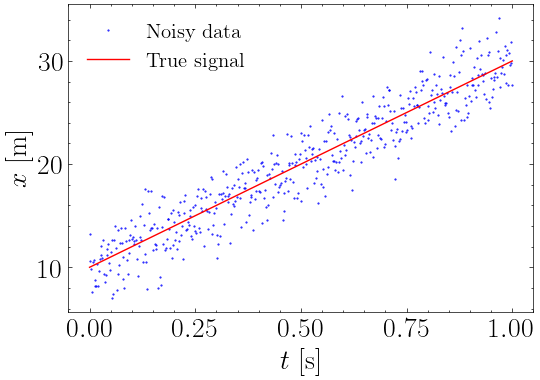

In [57]:
def forward_model(t, x0 = 10, v0 = 20): 
    return x0 + v0 * t

num_points = 500 # Number of measured data points
t = np.linspace(0, 1, num_points) # seconds
sigma = 2 # standard deviation (in meters) 
epsilon = np.random.normal(loc = 0, scale = sigma, size = (num_points,)) # meters
y = forward_model(t = t, x0 = x0, v0 = v0) + epsilon # meters

fig, axs = plt.subplots(1, 1, figsize = (6, 4))
ax = axs
ax.plot(t, y, ".", markersize = 1, label = "Noisy data", color = "b")
ax.plot(t, forward_model(t, x0, v0), label = "True signal", color = "r")
ax.set(xlabel = r"$t$ [s]", ylabel = r"$x$ [m]")
plt.legend()

Great, we have our noisy data and we now want to do our linear regression. Let's start with the frequentist linear regression

## Frequentist linear regression
In the frequentist linear regression, we can rewrite the measurement equation in matrix form: 
$$
\begin{align}
\\
y_t &= \beta_{0} + \beta_{1}t + \epsilon
\\
\mathbf{y} &= \begin{pmatrix}
\beta_0 + \beta_1 t_1 \\
\beta_0 + \beta_1 t_2 \\
\vdots \\
\beta_0 + \beta_1 t_m \\
\end{pmatrix}
\\
 &= \begin{pmatrix}
1 & t_1 \\
1 & t_2 \\
\vdots & \vdots \\
1 & t_m 
\end{pmatrix}
\begin{pmatrix}
\beta_{0} \\ \beta_{1} 
\end{pmatrix}
\end{align}
\\
= \mathbf{t} \beta + \boldsymbol{\epsilon}
$$
where $\mathbf{y} \in \mathbb{R}^{m}$ represents our collection of measurements, $m$ is the total number of measurements, $\mathbf{t}$ is our input variable (assumed to be perfectly known in a simple frequentist linear regression setting).   

In the frequentist linear regression, the optimal regression coefficients $\beta^\star$ are obtained by applying the formula (where here we map $\mathbf{t}\rightarrow \mathbf{x}$)
$$
\beta^{\star}=(\mathbf{x}^{T} \mathbf{x}+ \lambda)^{-1}\mathbf{x}^{T} \mathbf{y}
$$
We can also compute the covariance matrix on the optimal parameters $\beta^\star$ when the noise is Gaussian. We have 
$$
\text{Cov}(\beta^\star)=\sigma^2(\mathbf{x}^{T}\mathbf{x}+ \lambda)^{-1}
$$
where $\lambda$ is a Ridge regularization to make sure that the matrix is invertible. 

Let's set $\lambda=10^{-5}$ to start. 


In [44]:
# Computing optimal regression coefficients
X = np.column_stack([np.ones_like(t), t])
A = X.T @ X
ridge_reg = 0 
inv_mat = np.linalg.inv(A + ridge_reg)
beta_star = (inv_mat @ X.T @ y)

# Computing covariance 
cov = (sigma) ** 2 * inv_mat
stds = np.sqrt(np.diag(cov))

beta_gt = np.array([x0, v0])
y_pred = forward_model(t, *beta_star)
residuals = (y-y_pred) / sigma # normalized residuals
chi_squared = np.sum(residuals ** 2) / len(y) 
print("Ground-truth", *beta_gt)
print("Optimal regression parameters", beta_star)
print("Standard deviation ", stds)
print("Chi squared", chi_squared)

Ground-truth 10 20
Optimal regression parameters [10.08778639 19.89007211]
Standard deviation  [0.17861744 0.30921961]
Chi squared 0.9749148105329265


That's pretty good ! Our uncertainties are good and are really constraining what's going on here. Let's plot the fitted model vs the ground-truth model. 

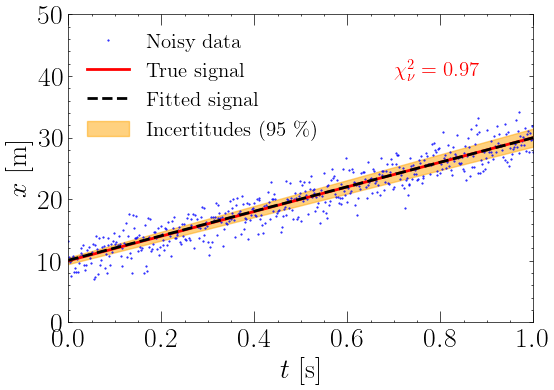

In [63]:
fig, axs = plt.subplots(1, 1, figsize = (6, 4))
ax = axs
ax.plot(t, y, ".", markersize = 1, label = "Noisy data", color = "b")
ax.plot(t, forward_model(t, *beta_gt), lw = 2, label = "True signal", color = "r")
ax.plot(t, forward_model(t, *beta_star), lw = 2, ls = "--", label = "Fitted signal", color = "k")

k = 3
y_min = forward_model(t, x0 = beta_gt[0] - k * stds[0], v0 = beta_gt[1] - k * stds[1]) 
y_max = forward_model(t, x0 = beta_gt[0] + k * stds[0], v0 = beta_gt[1] + k * stds[1])
ax.fill_between(t, y_min, y_max, color = "orange", alpha = 0.5, label = "Incertitudes (95 \%)")
ax.set(xlabel = r"$t$ [s]", ylabel = r"$x$ [m]", xlim = [0, 1], ylim = [0, 50])
ax.annotate(r"$\chi^{2}_{\nu} = %.2f$"%chi_squared, color = 'r', xy = (0.7, 0.8), xycoords = "axes fraction")
plt.legend()

This is working really great as it should in this setting. Traditional linear regression algorithms generally minimize the mean squared error, which means assuming Gaussian noise in our data. Why is minimizing the mean squared error assuming Gaussian noise ? Well, just writing the $\chi^2$, we have 
$$
\chi^2 = (\mathbf{y} - \mathbf{x}\beta)^{T}(\mathbf{y} - \mathbf{x} \beta)= ||\mathbf{y}-\mathbf{x}\beta||^2
$$
This is exactly the mean-squared error (up to a constant factor) :). So, when computing the minimum of the mean squared error, we in fact minimize the $\chi^2$ as well ! 

Let's make things a tiny bit more complex. Let's have a quadratic equation to fit instead. What to do, we only know how to fit linear equations right ? We now consider the case where there's a force in our system, let's say gravity. We have
$$
z(t) = z_0 + v_0 t - \frac{1}{2}gt^{2}
$$

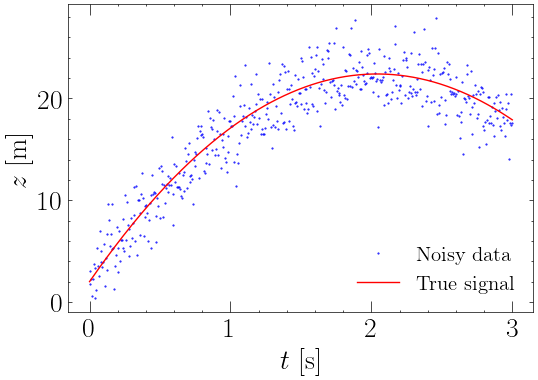

In [88]:
def forward_model(t, z0 = 10, v0 = 20, k = -0.5 * 9.8): 
    return z0 + v0 * t + k* t**2
# Initial conditions
g = 9.8
z0 = 2
v0 = 20

num_points = 500 # Number of measured data points
t = np.linspace(0, 3, num_points) # seconds
sigma = 2 # standard deviation (in meters) 
epsilon = np.random.normal(loc = 0, scale = sigma, size = (num_points,)) # meters
y = forward_model(t = t, z0 = z0, v0 = v0, k = - 0.5 * 9.8) + epsilon # meters

fig, axs = plt.subplots(1, 1, figsize = (6, 4))
ax = axs
ax.plot(t, y, ".", markersize = 1, label = "Noisy data", color = "b")
ax.plot(t, forward_model(t, z0, v0), label = "True signal", color = "r")
ax.set(xlabel = r"$t$ [s]", ylabel = r"$z$ [m]")
plt.legend()

We now create the design matrix $X$, the cool thing is that we can put the quadratic term in the first column of our design matrix and let our approach as it is right now ! 

In [92]:
# Computing optimal regression coefficients
X = np.column_stack([np.ones_like(t), t, t ** 2])
A = X.T @ X
ridge_reg = 0 
inv_mat = np.linalg.inv(A + ridge_reg)
beta_star = (inv_mat @ X.T @ y)

# Computing covariance 
cov = (sigma) ** 2 * inv_mat
stds = np.sqrt(np.diag(cov))

beta_gt = np.array([z0, v0, -0.5 * g])
y_pred = forward_model(t, *beta_star)
residuals = (y-y_pred) / sigma # normalized residuals
chi_squared = np.sum(residuals ** 2) / len(y) 
print("Ground-truth", *beta_gt)
print("Optimal regression parameters", beta_star)
print("Standard deviation ", stds)
print("Chi squared", chi_squared)

Ground-truth 2.0 20.0 -4.9
Optimal regression parameters [ 1.99137468 19.89646466 -4.90074975]
Standard deviation  [0.26725841 0.4115229  0.13280186]
Chi squared 1.03937753730613


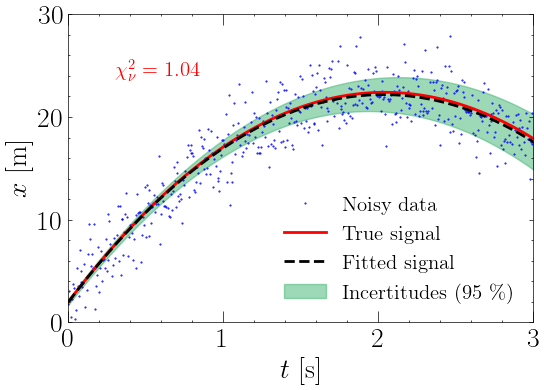

In [97]:
fig, axs = plt.subplots(1, 1, figsize = (6, 4))
ax = axs
ax.plot(t, y, ".", markersize = 1, label = "Noisy data", color = "b")
ax.plot(t, forward_model(t, *beta_gt), lw = 2, label = "True signal", color = "r")
ax.plot(t, forward_model(t, *beta_star), lw = 2, ls = "--", label = "Fitted signal", color = "k")

k = 1
model_params_min = beta_star - k * stds
model_params_max = beta_star + k * stds
y_min = forward_model(t, *model_params_min) 
y_max = forward_model(t, *model_params_max)
ax.fill_between(t, y_min, y_max, color = "mediumseagreen", alpha = 0.5, label = "Incertitudes (95 \%)")
ax.set(xlabel = r"$t$ [s]", ylabel = r"$x$ [m]", xlim = [0, 3], ylim = [0, 30])
ax.annotate(r"$\chi^{2}_{\nu} = %.2f$"%chi_squared, color = 'r', xy = (0.1, 0.8), xycoords = "axes fraction")
plt.legend()


Before moving to the next part, I'll raise a small problem with what we just did. Typically, in our experiments, we also want to incorporate the noise that comes on the $x$-axis (here our time measurement). Including this second uncertainty in the linear regression can be challenging in the frequentist approach but we can do it very simply doing a Bayesian linear regression.
### Bayesian linear regression